# Imports

In [75]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# set path to dataset 

In [76]:
DATA_PATH = 'data.csv' 

## Load dataset  and print a quick summary


In [77]:
df = pd.read_csv('data.csv')
print('Loaded dataset with shape:', df.shape)

Loaded dataset with shape: (9000, 10)


# Show top rows and info

In [78]:
display(df.head())
print('\nData info:')
df.info()
print('\nMissing values per column:')
print(df.isnull().sum())

,Employee_ID,Age,Department,Years_of_Experience,Monthly_Working_Hours,Training_Hours_per_Year,Performance_Rating,Job_Satisfaction_Level,Promotion_in_Last_2_Years,Attrition
0,E1000,59,Sales,27,135,30,3,Medium,Yes,No
1,E1001,49,Tech,13,132,36,5,Medium,Yes,Yes
2,E1002,35,Operations,16,197,11,5,Low,No,No
3,E1003,28,HR,23,204,36,3,High,No,No
4,E1004,41,Operations,33,192,36,2,Medium,No,No



Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Employee_ID                9000 non-null   object
 1   Age                        9000 non-null   int64 
 2   Department                 9000 non-null   object
 3   Years_of_Experience        9000 non-null   int64 
 4   Monthly_Working_Hours      9000 non-null   int64 
 5   Training_Hours_per_Year    9000 non-null   int64 
 6   Performance_Rating         9000 non-null   int64 
 7   Job_Satisfaction_Level     9000 non-null   object
 8   Promotion_in_Last_2_Years  9000 non-null   object
 9   Attrition                  9000 non-null   object
dtypes: int64(5), object(5)
memory usage: 703.3+ KB

Missing values per column:
Employee_ID                  0
Age                          0
Department                   0
Years_of_Experience          0
Monthly_Working_H

 ## Basic cleaning & preprocessing strategy
# Steps performed in the notebook:
# 1. Drop or fill missing values (simple strategy: drop rows with many missing or fill with median/mode).
# 2. Convert categorical columns (Department, Job Satisfaction Level, Promotion, Attrition) into numeric labels.
# 3. Feature engineering - if needed (e.g., years category, hours per week derived, etc.).
# 4. Prepare `X` and `y` for classification (Attrition) and regression (Performance Rating).























In [79]:
# Make a copy
data = df.copy()

# Standardize column names (strip spaces)


In [80]:
data.columns = [c.strip() for c in data.columns]

In [81]:
# Inspect expected columns
print('Columns:', list(data.columns))

Columns: ['Employee_ID', 'Age', 'Department', 'Years_of_Experience', 'Monthly_Working_Hours', 'Training_Hours_per_Year', 'Performance_Rating', 'Job_Satisfaction_Level', 'Promotion_in_Last_2_Years', 'Attrition']


In [82]:
# Fill missing values for numeric with median, categorical with mode

In [83]:
num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
for c in num_cols:
    if data[c].isnull().sum() > 0:
        data[c].fillna(data[c].median(), inplace=True)
for c in cat_cols:
    if data[c].isnull().sum() > 0:
        data[c].fillna(data[c].mode()[0], inplace=True)

print('\nAfter filling missing values:')
print(data.isnull().sum())


After filling missing values:
Employee_ID                  0
Age                          0
Department                   0
Years_of_Experience          0
Monthly_Working_Hours        0
Training_Hours_per_Year      0
Performance_Rating           0
Job_Satisfaction_Level       0
Promotion_in_Last_2_Years    0
Attrition                    0
dtype: int64


### Encode categorical variables
# We'll label-encode simple categorical fields. For multi-class or ordinal (Job Satisfaction: Low/Medium/High) we preserve ordering manually.

In [84]:
le = LabelEncoder()

# Common categorical columns based on task description
# 'Department', 'Job Satisfaction Level', 'Promotion in Last 2 Years', 'Attrition'
# Map possible column name variations to expected names

In [85]:
col_map = {}
for c in data.columns:
    lc = c.lower()
    if 'department' in lc:
        col_map['Department'] = c
    if 'satisfaction' in lc:
        col_map['JobSatisfaction'] = c
    if 'promotion' in lc or 'promoted' in lc:
        col_map['Promotion'] = c
    if 'attrit' in lc or 'left' in lc or 'resign' in lc:
        col_map['Attrition'] = c
    if 'performance' in lc and 'rating' in lc:
        col_map['PerformanceRating'] = c

print('\nColumn mapping detected:', col_map)


Column mapping detected: {'Department': 'Department', 'PerformanceRating': 'Performance_Rating', 'JobSatisfaction': 'Job_Satisfaction_Level', 'Promotion': 'Promotion_in_Last_2_Years', 'Attrition': 'Attrition'}


# Apply encodings

In [86]:
def safe_label_encode(df, col, mapping=None, ordered_categories=None):
    if col not in df.columns:
        return df
    if ordered_categories is not None:
        # create a categorical with order
        df[col] = pd.Categorical(df[col], categories=ordered_categories, ordered=True)
        df[col] = df[col].cat.codes
    else:
        try:
            df[col] = le.fit_transform(df[col].astype(str))
        except Exception:
            df[col] = df[col].astype('category').cat.codes
    return df

In [87]:
if 'Department' in col_map:
    data = safe_label_encode(data, col_map['Department'])
if 'JobSatisfaction' in col_map:
    # If job satisfaction is Low/Medium/High order it
    js_col = col_map['JobSatisfaction']
    unique_vals = data[js_col].dropna().unique()
    ordered = None
    # if typical levels present
    typical = ['Low', 'Medium', 'High']
    if all(x in unique_vals for x in typical):
        ordered = typical
    data = safe_label_encode(data, js_col, ordered_categories=ordered)
if 'Promotion' in col_map:
    # yes/no map
    pcol = col_map['Promotion']
    data[pcol] = data[pcol].astype(str).str.strip().replace({'Yes':'Yes','No':'No','yes':'Yes','no':'No'})
    data = safe_label_encode(data, pcol)
if 'Attrition' in col_map:
    acol = col_map['Attrition']
    data[acol] = data[acol].astype(str).str.strip().replace({'Yes':'Yes','No':'No','yes':'Yes','no':'No'})
    data = safe_label_encode(data, acol)

# If Performance rating exists, ensure numeric
if 'PerformanceRating' in col_map:
    pr = col_map['PerformanceRating']
    try:
        data[pr] = pd.to_numeric(data[pr])
    except Exception:
        data[pr] = data[pr].astype('category').cat.codes


In [88]:
# Show processed head
display(data.head())
#features
features = [c for c in data.columns if 'employee' not in c.lower()]
print('Candidate features:', features)


,Employee_ID,Age,Department,Years_of_Experience,Monthly_Working_Hours,Training_Hours_per_Year,Performance_Rating,Job_Satisfaction_Level,Promotion_in_Last_2_Years,Attrition
0,E1000,59,3,27,135,30,3,1,1,0
1,E1001,49,4,13,132,36,5,1,1,1
2,E1002,35,2,16,197,11,5,0,0,0
3,E1003,28,1,23,204,36,3,2,0,0
4,E1004,41,2,33,192,36,2,1,0,0


Candidate features: ['Age', 'Department', 'Years_of_Experience', 'Monthly_Working_Hours', 'Training_Hours_per_Year', 'Performance_Rating', 'Job_Satisfaction_Level', 'Promotion_in_Last_2_Years', 'Attrition']


In [89]:
# Choose label columns if present
attrition_col = col_map.get('Attrition', None)
perf_col = col_map.get('PerformanceRating', None)
print('Attrition column:', attrition_col, '\nPerformance column:', perf_col)

Attrition column: Attrition 
Performance column: Performance_Rating


In [90]:
# Basic feature set (drop label columns from features)
X_cols = [c for c in features if c not in [attrition_col, perf_col]]
print('X columns used:', X_cols)

X columns used: ['Age', 'Department', 'Years_of_Experience', 'Monthly_Working_Hours', 'Training_Hours_per_Year', 'Job_Satisfaction_Level', 'Promotion_in_Last_2_Years']


## Train/Test split & scaling helper

In [91]:
def prepare_data_for_classification(df, X_cols, label_col, test_size=0.2, random_state=42, scale=True):
    X = df[X_cols].copy()
    y = df[label_col].copy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)
    if scale:
        scaler = StandardScaler()
        X_train[X_train.columns] = scaler.fit_transform(X_train)
        X_test[X_test.columns] = scaler.transform(X_test)
        return X_train, X_test, y_train, y_test, scaler
    else:
        return X_train, X_test, y_train, y_test, None

In [92]:
# For regression
def prepare_data_for_regression(df, X_cols, label_col, test_size=0.2, random_state=42, scale=True):
    X = df[X_cols].copy()
    y = df[label_col].copy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    if scale:
        scaler = StandardScaler()
        X_train[X_train.columns] = scaler.fit_transform(X_train)
        X_test[X_test.columns] = scaler.transform(X_test)
        return X_train, X_test, y_train, y_test, scaler
    else:
        return X_train, X_test, y_train, y_test, None

# Task 1a: Random Forest Classification (Attrition)

In [93]:
if attrition_col is not None:
    print('\n=== Random Forest Classification: Attrition ===')
    X_train, X_test, y_train, y_test, scaler = prepare_data_for_classification(data, X_cols, attrition_col)
    clf = RandomForestClassifier(n_estimators=200, random_state=42)
    t0 = time.time()
    clf.fit(X_train, y_train)
    t1 = time.time()
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='binary', zero_division=0)
    rec = recall_score(y_test, y_pred, average='binary', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)
    print('Accuracy:', acc)
    print('Precision:', prec)
    print('Recall:', rec)
    print('F1:', f1)
    print('Training time (s):', t1 - t0)
    print('\nClassification report:\n', classification_report(y_test, y_pred))



=== Random Forest Classification: Attrition ===
Accuracy: 0.8033333333333333
Precision: 0.2
Recall: 0.002849002849002849
F1: 0.0056179775280898875
Training time (s): 4.432855129241943

Classification report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.89      1449
           1       0.20      0.00      0.01       351

    accuracy                           0.80      1800
   macro avg       0.50      0.50      0.45      1800
weighted avg       0.69      0.80      0.72      1800



In [94]:

# Feature importance (tree-based)
fi = pd.Series(clf.feature_importances_, index=X_train.columns)
print('\nTop features by importance:')
display(fi.head(10))


Top features by importance:


Age                          0.198736
Department                   0.074363
Years_of_Experience          0.193137
Monthly_Working_Hours        0.250784
Training_Hours_per_Year      0.216875
Job_Satisfaction_Level       0.048211
Promotion_in_Last_2_Years    0.017894
dtype: float64

In [95]:
# Permutation importance (on test set)
perm = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)
perm_imp = pd.Series(perm.importances_mean, index=X_test.columns).sort_values(ascending=False)
print('\nTop features by permutation importance:')
display(perm_imp.head(10))


Top features by permutation importance:


Job_Satisfaction_Level       0.002222
Training_Hours_per_Year      0.001444
Age                          0.001056
Promotion_in_Last_2_Years    0.000556
Years_of_Experience          0.000444
Monthly_Working_Hours        0.000444
Department                  -0.000667
dtype: float64

In [96]:
# First cell
results = {}   # initialize dictionary

# Later cell
results['rf_classification'] = {
    'model': clf,
    'accuracy': acc,
    'precision': prec,
    'recall': rec,
    'f1': f1,
    'train_time': t1 - t0,
    'feature_importance': fi,
    'permutation_importance': perm_imp
}

# Check it
print(results['rf_classification'])


{'model': RandomForestClassifier(n_estimators=200, random_state=42), 'accuracy': 0.8033333333333333, 'precision': 0.2, 'recall': 0.002849002849002849, 'f1': 0.0056179775280898875, 'train_time': 4.432855129241943, 'feature_importance': Age                          0.198736
Department                   0.074363
Years_of_Experience          0.193137
Monthly_Working_Hours        0.250784
Training_Hours_per_Year      0.216875
Job_Satisfaction_Level       0.048211
Promotion_in_Last_2_Years    0.017894
dtype: float64, 'permutation_importance': Job_Satisfaction_Level       0.002222
Training_Hours_per_Year      0.001444
Age                          0.001056
Promotion_in_Last_2_Years    0.000556
Years_of_Experience          0.000444
Monthly_Working_Hours        0.000444
Department                  -0.000667
dtype: float64}


# Task 1b: Random Forest Regression (Performance Rating)

In [97]:
if perf_col is not None:
    print('\n=== Random Forest Regression: Performance Rating ===')
    X_train_r, X_test_r, y_train_r, y_test_r, scaler_r = prepare_data_for_regression(data, X_cols, perf_col)
    regr = RandomForestRegressor(n_estimators=200, random_state=42)
    t0 = time.time()
    regr.fit(X_train_r, y_train_r)
    t1 = time.time()
    y_pred_r = regr.predict(X_test_r)
    mse = mean_squared_error(y_test_r, y_pred_r)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_r, y_pred_r)
    print('RMSE:', rmse)
    print('R2:', r2)

    fi_r = pd.Series(regr.feature_importances_, index=X_train_r.columns).sort_values(ascending=False)
    print('\nTop features by importance (regression):')
    display(fi_r.head(10))

    results['rf_regression'] = {
        'model': regr,
        'rmse': rmse,
        'r2': r2,
        'train_time': t1 - t0,
        'feature_importance': fi_r
    }


=== Random Forest Regression: Performance Rating ===
RMSE: 1.1528274420359323
R2: -0.0473216657148503

Top features by importance (regression):


Monthly_Working_Hours        0.247956
Training_Hours_per_Year      0.212080
Years_of_Experience          0.193218
Age                          0.187925
Department                   0.085016
Job_Satisfaction_Level       0.053900
Promotion_in_Last_2_Years    0.019905
dtype: float64

 # Task 2: Support Vector Machine (SVM) - Attrition classification
# We'll train SVMs with linear, polynomial, and RBF kernels and compa

In [101]:
if attrition_col is not None:
    print('\n=== SVM Classification (kernels comparison) ===')
    X_train_s, X_test_s, y_train_s, y_test_s, scaler_s = prepare_data_for_classification(data, X_cols, attrition_col)

    svm_kernels = ['linear', 'poly', 'rbf']
    svm_results = {}
    for kernel in svm_kernels:
        print(f'\nTraining SVM with kernel={kernel}')
        if kernel == 'poly':
            model = SVC(kernel=kernel, degree=3, probability=False, random_state=42)
        else:
            model = SVC(kernel=kernel, probability=False, random_state=42)
        t0 = time.time()
        model.fit(X_train_s, y_train_s)
        t1 = time.time()
        y_pred_s = model.predict(X_test_s)
        acc = accuracy_score(y_test_s, y_pred_s)
        prec = precision_score(y_test_s, y_pred_s, average='binary', zero_division=0)
        rec = recall_score(y_test_s, y_pred_s, average='binary', zero_division=0)
        f1 = f1_score(y_test_s, y_pred_s, average='binary', zero_division=0)
        print('Accuracy:', acc, 'Precision:', prec, 'Recall:', rec, 'F1:', f1, 'Train time:', t1 - t0)
        svm_results[kernel] = {
            'model': model,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'train_time': t1 - t0
        }

    results['svm'] = svm_results


=== SVM Classification (kernels comparison) ===

Training SVM with kernel=linear
Accuracy: 0.805 Precision: 0.0 Recall: 0.0 F1: 0.0 Train time: 0.9770822525024414

Training SVM with kernel=poly
Accuracy: 0.805 Precision: 0.0 Recall: 0.0 F1: 0.0 Train time: 1.1803772449493408

Training SVM with kernel=rbf
Accuracy: 0.805 Precision: 0.0 Recall: 0.0 F1: 0.0 Train time: 6.5986878871917725


# Task 3: XGBoost Classification (Attrition) + Hyperparameter tuning
# We'll run a basic XGBoost classifier and then do a RandomizedSearchCV for a few important hyperparameters.

In [102]:
if attrition_col is not None:
    print('\n=== XGBoost Classification & Tuning ===')
    X_train_x, X_test_x, y_train_x, y_test_x, scaler_x = prepare_data_for_classification(data, X_cols, attrition_col)
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    t0 = time.time()
    xgb.fit(X_train_x, y_train_x)
    t1 = time.time()
    y_pred_x = xgb.predict(X_test_x)
    acc = accuracy_score(y_test_x, y_pred_x)
    prec = precision_score(y_test_x, y_pred_x, average='binary', zero_division=0)
    rec = recall_score(y_test_x, y_pred_x, average='binary', zero_division=0)
    f1 = f1_score(y_test_x, y_pred_x, average='binary', zero_division=0)
    print('Baseline XGBoost - Accuracy:', acc, 'Precision:', prec, 'Recall:', rec, 'F1:', f1, 'Train time:', t1 - t0)

    # Hyperparameter tuning (RandomizedSearch for speed) - quick search space
    param_dist = {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [3, 4, 6, 8],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.5, 0.7, 1.0]
    }
    xgb_rs = RandomizedSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
                                param_distributions=param_dist,
                                n_iter=20,
                                scoring='accuracy',
                                cv=3,
                                verbose=1,
                                random_state=42,
                                n_jobs=-1)
    t0 = time.time()
    xgb_rs.fit(X_train_x, y_train_x)
    t1 = time.time()
    print('Best params:', xgb_rs.best_params_)
    best_xgb = xgb_rs.best_estimator_
    y_pred_xb = best_xgb.predict(X_test_x)
    acc_b = accuracy_score(y_test_x, y_pred_xb)
    prec_b = precision_score(y_test_x, y_pred_xb, average='binary', zero_division=0)
    rec_b = recall_score(y_test_x, y_pred_xb, average='binary', zero_division=0)
    f1_b = f1_score(y_test_x, y_pred_xb, average='binary', zero_division=0)
    print('Tuned XGBoost - Accuracy:', acc_b, 'Precision:', prec_b, 'Recall:', rec_b, 'F1:', f1_b, 'Tuning time:', t1 - t0)



=== XGBoost Classification & Tuning ===
Baseline XGBoost - Accuracy: 0.7744444444444445 Precision: 0.1686746987951807 Recall: 0.039886039886039885 F1: 0.06451612903225806 Train time: 0.5918850898742676
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'subsample': 0.6, 'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
Tuned XGBoost - Accuracy: 0.805 Precision: 0.0 Recall: 0.0 F1: 0.0 Tuning time: 4.002607107162476


In [103]:
# Feature importance
fi_xgb = pd.Series(best_xgb.feature_importances_, index=X_train_x.columns).sort_values(ascending=False)
print('\nTop features by XGBoost importance:')
display(fi_xgb.head(10))


Top features by XGBoost importance:


Monthly_Working_Hours        0.164649
Training_Hours_per_Year      0.155501
Age                          0.146251
Years_of_Experience          0.145534
Promotion_in_Last_2_Years    0.145057
Department                   0.124817
Job_Satisfaction_Level       0.118192
dtype: float32

In [104]:
results['xgboost'] = {
            'baseline': {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'train_time': t1 - t0},
            'tuned': {'model': best_xgb, 'accuracy': acc_b, 'precision': prec_b, 'recall': rec_b, 'f1': f1_b, 'tuning_time': t1 - t0, 'feature_importance': fi_xgb}
        }


## Compare models (classification summary table)

In [105]:
if attrition_col is not None:
    rows = []
    # Random Forest
    if 'rf_classification' in results:
        r = results['rf_classification']
        rows.append(('RandomForest', r['accuracy'], r['precision'], r['recall'], r['f1'], r['train_time']))
    # SVM kernels
    if 'svm' in results:
        for k,v in results['svm'].items():
            rows.append((f'SVM-{k}', v['accuracy'], v['precision'], v['recall'], v['f1'], v['train_time']))
    # XGBoost tuned
    if 'xgboost' in results:
        xb = results['xgboost']['tuned']
        rows.append(('XGBoost-tuned', xb['accuracy'], xb['precision'], xb['recall'], xb['f1'], xb['tuning_time']))

    comp_df = pd.DataFrame(rows, columns=['model','accuracy','precision','recall','f1','time_s']).sort_values('accuracy', ascending=False)
    display(comp_df)

,model,accuracy,precision,recall,f1,time_s
1,SVM-linear,0.805000,0.0,0.000000,0.000000,0.977082
3,SVM-rbf,0.805000,0.0,0.000000,0.000000,6.598688
2,SVM-poly,0.805000,0.0,0.000000,0.000000,1.180377
4,XGBoost-tuned,0.805000,0.0,0.000000,0.000000,4.002607
0,RandomForest,0.803333,0.2,0.002849,0.005618,4.432855


 ## Plots: feature importance comparison (top 10)


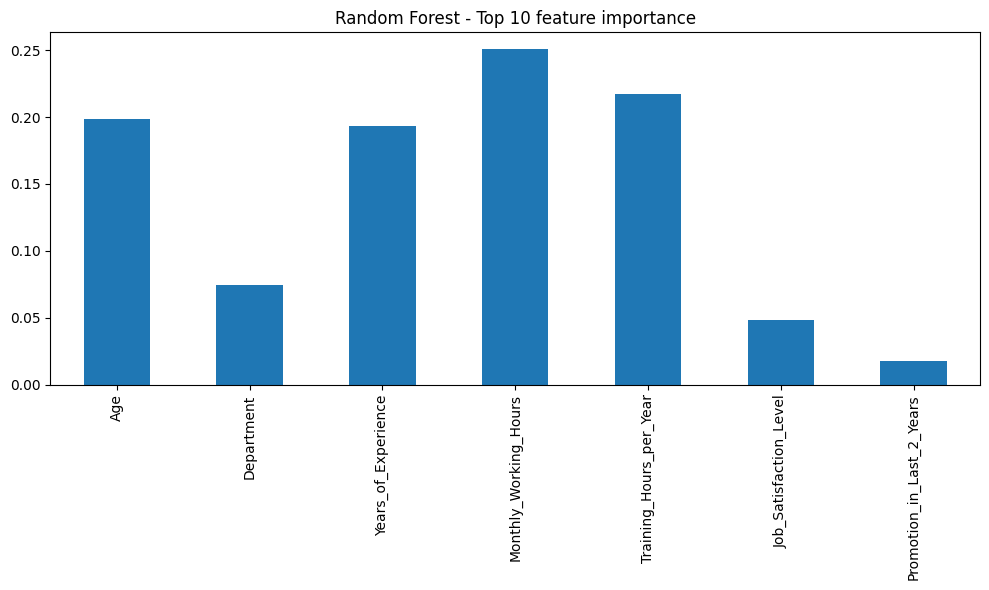

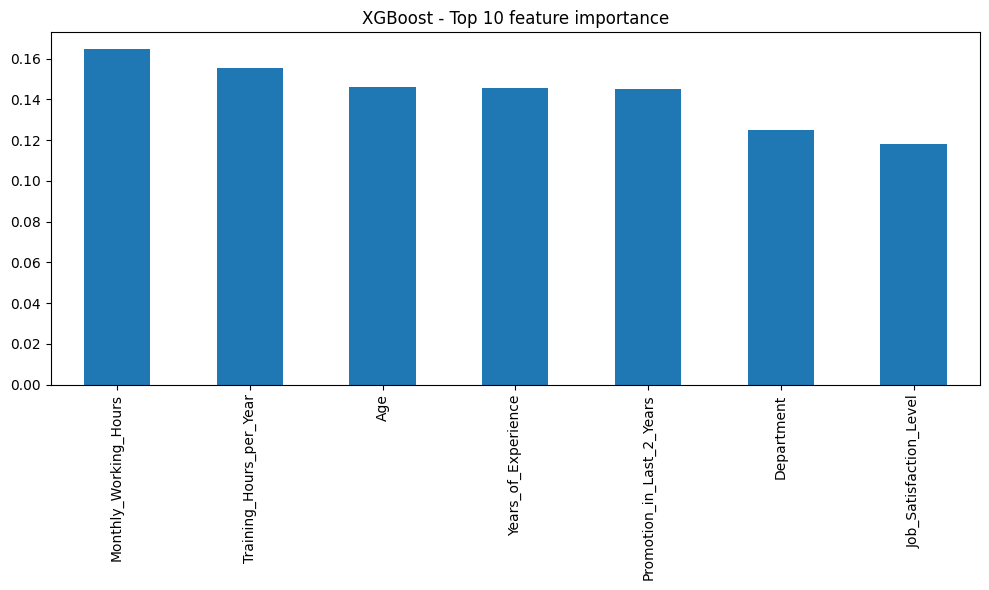

In [106]:
if attrition_col is not None:
    plt.figure(figsize=(10,6))
    if 'rf_classification' in results:
        fi = results['rf_classification']['feature_importance'].head(10)
        fi.plot(kind='bar');
        plt.title('Random Forest - Top 10 feature importance')
        plt.tight_layout()
        plt.show()
    if 'xgboost' in results:
        fi2 = results['xgboost']['tuned']['feature_importance'].head(10)
        plt.figure(figsize=(10,6))
        fi2.plot(kind='bar')
        plt.title('XGBoost - Top 10 feature importance')
        plt.tight_layout()
        plt.show()

In [107]:
save_models = False
if save_models:
    import joblib
    if 'rf_classification' in results:
        joblib.dump(results['rf_classification']['model'], 'rf_classification.pkl')
    if 'rf_regression' in results:
        joblib.dump(results['rf_regression']['model'], 'rf_regression.pkl')
    if 'svm' in results:
        for k,v in results['svm'].items():
            joblib.dump(v['model'], f'svm_{k}.pkl')
    if 'xgboost' in results:
        joblib.dump(results['xgboost']['tuned']['model'], 'xgboost_tuned.pkl')
    print('Models saved')